In [4]:
#import image from the computer
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
import imageio
from findpeaks import findpeaks
import scipy as sp
from scipy.stats import norm

volume_properties= []

In [5]:
# vol properties by number of pixels 

def print_color(r,g,b):
    final_color=np.ones((30,30,3))
    final_color[:,:,0]=  r
    final_color[:,:,1]=  g
    final_color[:,:,2]=  b 
    #stack 
    final_color = cv.convertScaleAbs(final_color)
    return final_color
    
def show_vp(volume_properties, top=len(volume_properties), show=0):
    plt.figure()
    for i in range(0,top):
        #divide by 5 and round up
        plt.subplot(len(volume_properties)//5 +1, 5, i+1)
        color_image = print_color(volume_properties[i][2],volume_properties[i][3],volume_properties[i][4])
        plt.imshow(color_image)
        if show:
            plt.title(str(volume_properties[i][0])+ ',\n rgb: '+ str(volume_properties[i][2])+','+str(volume_properties[i][3])+','+str(volume_properties[i][4]))
        #dont show axis
        plt.xticks([])
        plt.yticks([])
        #make titles small
        plt.rcParams.update({'font.size': 6})
        #title to the right of image
        plt.subplots_adjust(right=0.8)
        #make break between images
        #plt.subplots_adjust(hspace=2.5)
        #plt.subplots_adjust(wspace=0.5)

# current functions

def count_pixels(saved_masked_img):
    pixel_total_masked = 0
    for i in range(0, saved_masked_img.shape[0]):
        for j in range(0, saved_masked_img.shape[1]):
            if saved_masked_img[i][j][0] != 0:
                pixel_total_masked += 1
    return pixel_total_masked

def thresholding(threshold, historgram):
    pulse_start_end= []
    hist_pulse_area= []
    hist_tr= historgram > threshold
    hist_tr = hist_tr.astype(int)

    hist_total_pulse_area= np.sum(hist_tr)
   # add tolerance to the thresholding
    max_tol= 1
    tol1=0
    tol2=0
    if hist_tr[0]==1:
        pulse_start_end.append(0)
    for i in range(1, len(hist_tr)):
        if hist_tr[i] == 1 and hist_tr[i-1] == 0:
            tol1=tol1 + 1
            if tol1==max_tol:
                pulse_start_end.append(i)
                tol1=0
        if hist_tr[i] == 0 and hist_tr[i-1] == 1:
            tol2=tol2 + 1
            if tol2==max_tol:
                pulse_start_end.append(i)
                tol2=0

    if hist_tr[-1]==1:
        pulse_start_end.append(len(hist_tr))

    for i in range(0, len(pulse_start_end)//2 ):
        hist_pulse_area.append(np.sum(hist_tr[pulse_start_end[2*i]:pulse_start_end[2*i+1]]))
        hist_tr[pulse_start_end[2*i]:pulse_start_end[2*i +1]] = hist_pulse_area[i]
    return hist_tr, hist_pulse_area, pulse_start_end

def make_new_image(rgb_img, mask):
    red = rgb_img[:,:,0]*mask
    green = rgb_img[:,:,1]*mask
    blue = rgb_img[:,:,2]*mask
    masked_img = np.dstack((red,green,blue))
    return masked_img

def make_material_image(masked_img,hue, saturation,value, material_colors_img, material_shading_img):

    # make a new image with the material color
    # for each pixel in the masked image that is not zero, set the hue, saturation, and value
    # of the pixel in the material color image to the hue, saturation, and value of the pixel

    for i in range(0, masked_img.shape[0]):
        for j in range(0, masked_img.shape[1]):
            if masked_img[i][j][0] != 0: # if the pixel is not black
                material_colors_img[i][j][0] = hue
                material_colors_img[i][j][1] = saturation
                material_colors_img[i][j][2] = value

                # make a new image with the material shading
                material_shading_img[i][j][0] = 125
                material_shading_img[i][j][1] = 0.5*(masked_img[i][j][1] - saturation) + 125
                material_shading_img[i][j][2] = 0.5*(masked_img[i][j][2] - value) + 125

    return material_colors_img, material_shading_img

In [6]:
#new functions for this notebook
from sklearn.neighbors import KernelDensity

def find_peaks(h,total_pixels_img):
    #smooth histogram while retainging number of pixels via kernel densirty estimation
    plt.figure()
    sampling,kde_hist= kde(h,total_pixels_img,0.01, sampling=np.linspace(0,255,256))  
    plt.plot(np.exp(kde_hist), label="0.5")

    sampling,kde_hist= kde(h,total_pixels_img,0.5, sampling=np.linspace(0,255,256))  
    plt.plot(np.exp(kde_hist), label="0.5")

    sampling,kde_hist= kde(h,total_pixels_img,1, sampling=np.linspace(0,255,256))
    plt.plot(np.exp(kde_hist), label="1")

    sampling,kde_hist= kde(h,total_pixels_img,50, sampling=np.linspace(0,255,256))
    plt.plot(np.exp(kde_hist), label="2")
  
    #display both histograms
    #plt.plot(hist, color='g', label="histogram")
    plt.legend()
    plt.title('Histograms')
    
    # find the peaks and areas of the region using thresholding ( number of pixels)
    # using the peak and number of pixels find the range of numbers that have the same number of pixels


def kde(x,total_pixels_img,h, sampling=np.linspace(-10,10,100)):
    kde = KernelDensity(kernel='gaussian', bandwidth=h).fit(x)
    log_prob= kde.score_samples(x)
    
    return (sampling,log_prob)

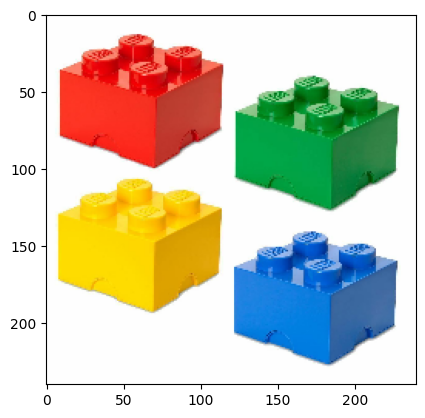

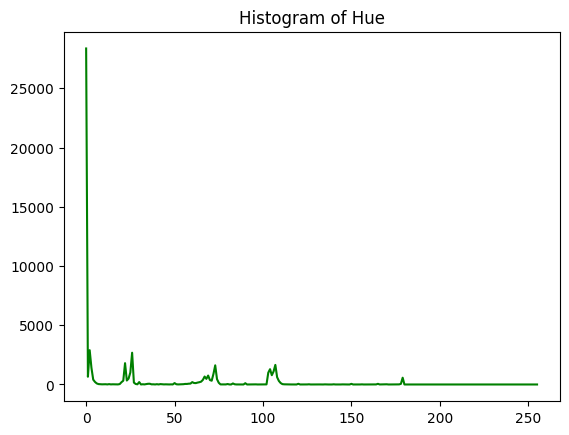

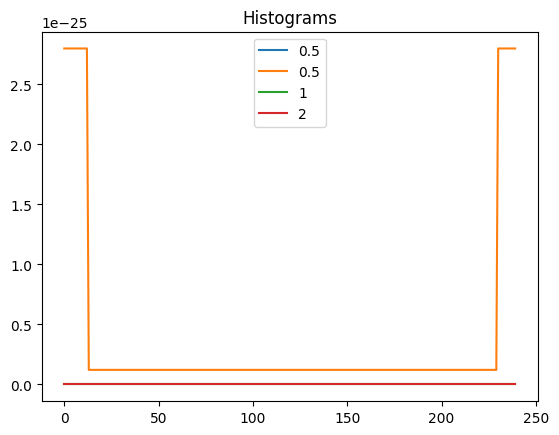

In [51]:
volume_properties= []
rgb_img = imageio.imread("photos/lego_sample.png")
plt.imshow(rgb_img)

hsv_img = cv.cvtColor(rgb_img, cv.COLOR_RGB2HSV)
pixel_total= hsv_img.shape[0]*hsv_img.shape[1]
saved_masked_img= rgb_img

h = hsv_img[:,:,0]
hist_h = cv.calcHist([h],[0],None,[256],[0,256])
total_pixels_img= count_pixels(hsv_img)

#plot 
plt.figure()
plt.plot(hist_h, color='g', label="histogram")
plt.title('Histogram of Hue')


find_peaks(h, total_pixels_img)

#peaks,fp_scipy = sp.signal.find_peaks(hist_h.transpose()[0], prominence = total_pixels_img*0.01, distance = 7, wlen=40)
   

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from scipy.signal import find_peaks, peak_widths

def n_pixels_of_peak(histogram, peaks):
    #find bases where gradient is zero
    #calculate the number of pixels of the peak on each side of the peak until the bases 
    histogram_gradient= np.gradient(histogram)
    

    n_left_of_peak = np.zeros(len(peaks))
    n_right_of_peak = np.zeros(len(peaks))
    left_base = np.zeros(len(peaks))
    right_base = np.zeros(len(peaks))

    for b in range(len(peaks)):
        # find left base
        #previous_value = histogram[peaks[int]] 
        location= int(peaks[b])

        n_left_of_peak[b]= (histogram[location])/2
        if location == 0:
              n_left_of_peak[b]= histogram[location]
        i  = location - 1
        while histogram_gradient[i]  > 0 and i > 0:
            n_left_of_peak[b] += histogram[i]
            #previous_value = histogram[i]
            i=i-1
        left_base[b] = i

        # find right base
        #previous_value = histogram[peaks[int]]
        n_right_of_peak[b]= histogram[location]/2
        if location == len(histogram)-1:
           n_right_of_peak[b]= histogram[location]
        i  = location + 1
        while histogram_gradient[i]  <0  and i < (len(histogram)-2):
            n_right_of_peak[b] += histogram[i]
            #previous_value = histogram[i]
            i=i+1
        right_base[b] = i
   
    return n_left_of_peak, n_right_of_peak, left_base, right_base

def new_bases(histogram, peaks, n_left_of_peak, n_right_of_peak, left_base, right_base):

    #calculate the new bases for the peaks

    new_left_bases = np.zeros(len(peaks))
    new_right_bases = np.zeros(len(peaks))

    for c in range(len(peaks)-1):
        counter = 0
        location= int(peaks[c])
    
        while n_left_of_peak[c]>0 and (location-counter)> left_base[c]:
            n_left_of_peak[c] -= histogram[(location-counter)]
            counter += 1

        new_left_bases[c] = location - counter

        counter=0
        while n_right_of_peak[c]>0 and ( location +counter)<right_base[c]:
            n_right_of_peak[c] -= histogram[location +counter]
            counter += 1

        new_right_bases[c] = location + counter

    return new_left_bases, new_right_bases

def remove_small_peaks(histogram,peaks,threshold):
    #remove peaks that are smaller than threshold
    new_peaks = np.zeros(len(peaks))
    counter=0
    for i in range(len(peaks)):
        if histogram[peaks[i]] > threshold:
            new_peaks[counter] = int(peaks[i])
            counter += 1
    new_peaks = new_peaks[:counter]
    new_peaks = new_peaks.astype(int)
    return new_peaks

def calc_hue_kde(hue_values, total_pixels_img):
    plt.figure()  
    histogram= plt.hist(hue_values, bins=256, range=[0, 256], color='blue', alpha=0.7)

    # Calculate the KDE (Kernel Density Estimation) of hues
    kde = gaussian_kde(hue_values)

    # Plot the KDE
    x_vals = np.linspace(0, 255, 1000)
    x_integers = np.arange(0, 256)
    peaks,fp_scipy = find_peaks(kde(x_vals), distance = 7)
    for peakindex in range(len(peaks)):
        peaks[peakindex]= peaks[peakindex]*(256/1000)
    peaks= remove_small_peaks(histogram[0],peaks, total_pixels_img*0.001)
    kde_histogram=  kde(x_integers)*total_pixels_img
   
    n_left_of_peak, n_right_of_peak, l_bases, r_bases = n_pixels_of_peak( kde_histogram, peaks) 
    new_left_bases, new_right_bases= new_bases(histogram[1], peaks, n_left_of_peak, n_right_of_peak, l_bases, r_bases)
    # Plot the histogram

     
    ''' #plt.hist(hue_values, bins=256, range=[0, 256], color='blue', alpha=0.7)
    plt.scatter(peaks, histogram[0][peaks], color='red')
    plt.scatter(new_left_bases, histogram[0][new_left_bases.astype(int)], color='green', marker='x')
    plt.scatter(new_right_bases, histogram[0][new_right_bases.astype(int)], color='green', marker='x')
    # show bases left to right as line on plot 
     
    
    plt.title('Histogram of Hues')
    plt.xlabel('Hue Value')
    plt.ylabel(' Number of Pixels')'''

    plt.figure()   
    plt.plot(x_integers, kde_histogram, color='red', alpha=0.7)
    plt.scatter(x_integers[peaks], kde_histogram[peaks], color='blue')
    plt.fill_between(x_integers, 0, kde_histogram, color='red', alpha=0.1)
    plt.scatter( l_bases, kde_histogram[l_bases.astype(int)], color='green', marker='x')
    plt.scatter( r_bases, kde_histogram[r_bases.astype(int)], color='green', marker='x')
    plt.title('KDE of Hues')
    plt.xlabel('Hue Value')
    plt.ylabel('Density')

    plt.tight_layout()
    plt.show()

    return peaks, new_left_bases, new_right_bases

def calc_sat_kde(sat_values, total_pixels_img, threshold):
    plt.figure()  

    # Calculate the KDE (Kernel Density Estimation) of hues
    kde = gaussian_kde(sat_values)

    # Plot the KDE
    x_vals = np.linspace(0, 255, 1000)
    x_integers = np.arange(0, 256)
    kde_histogram=  kde(x_integers)*total_pixels_img
    
    #thresholding 
    s_hist_tr, s_hist_pulse_area, s_pulse_start_end= thresholding(threshold, kde_histogram)
    s_zeros= np.zeros(len(s_pulse_start_end))
    plt.figure()   
    plt.plot(x_integers, kde_histogram, color='red', alpha=0.7)
    plt.scatter( s_pulse_start_end,s_zeros,  color='blue')
    plt.title('KDE of Saturation')
    plt.xlabel('Hue Value')
    plt.ylabel('Density')

    plt.tight_layout()
    plt.show()

    return kde_histogram, s_pulse_start_end

def calc_val_kde(val_values, total_pixels_img, percentage):

    # Calculate the KDE (Kernel Density Estimation) of hues
    kde = gaussian_kde(val_values)

    # Plot the KDE
    x_vals = np.linspace(0, 255, 1000)
    x_integers = np.arange(0, 256)
    kde_histogram=  kde(x_integers)*total_pixels_img
    
    cdf = np.cumsum(kde_histogram)
    v_pulse = np.where(cdf<= percentage*cdf[-1] )
    v_array= v_pulse[0]
    if len(v_array)==0:
        v_end= 0
        print('no value detected:set to 0')
    else:
        v_end= v_array[-1]
        print(v_end, 'v_end')
   
    return kde_histogram, v_end


[ 31.  75. 107. 149.   0.] [ 76. 108. 134. 151.   0.] new bases


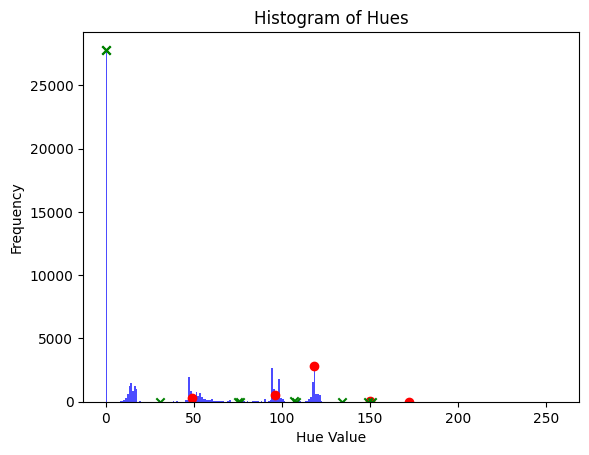

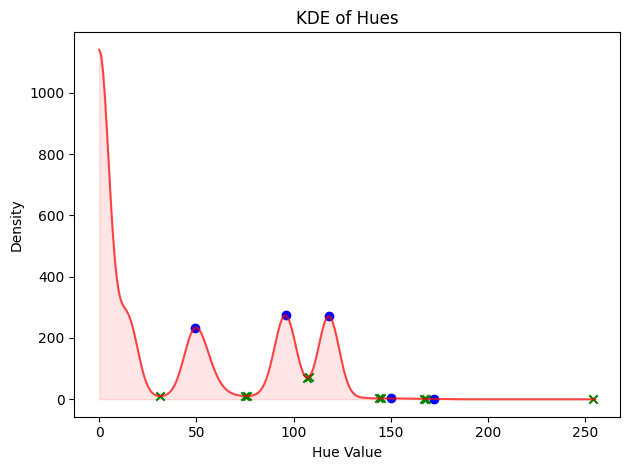

In [18]:
#rgb_img = imageio.imread("photos/pretty_image.png")
rgb_img = cv2.imread("photos/lego_sample.png")

hsv_img = cv.cvtColor(rgb_img, cv.COLOR_RGB2HSV)

pixel_total= hsv_img.shape[0]*hsv_img.shape[1]
saved_masked_img= rgb_img

total_pixels_img= count_pixels(hsv_img)

# extract and Flatten the hue channel
hue_channel = hsv_img[:,:,0]
hue_values = hue_channel.flatten()

hue_peaks, left_bases, right_bases= calc_hue_kde(hue_values, total_pixels_img)



In [8]:
def hsv_analysis_new(rgb_img,show_graphs= False):
    material_colors_img, material_shading_img= np.zeros((rgb_img.shape[0],rgb_img.shape[1],3)), np.zeros((rgb_img.shape[0],rgb_img.shape[1],3))
    hsv_img = cv.cvtColor(rgb_img, cv.COLOR_RGB2HSV)

    pixel_total= hsv_img.shape[0]*hsv_img.shape[1]
    saved_masked_img= rgb_img

    total_pixels_img= count_pixels(hsv_img)

    # extract and Flatten the hue channel
    hue_channel = hsv_img[:,:,0]
    hue_values = hue_channel.flatten()

    hue_peaks, left_bases, right_bases= calc_hue_kde(hue_values, total_pixels_img)

    # sort them by size of prominence

    #itterate for each hue found
    print('There are ',len(hue_peaks),'Hue peaks')
    for hue_material_number in range(len(hue_peaks)):

        #mask for object segmentation
        lower_mask = hsv_img[:,:,0] > left_bases[hue_material_number] 
        upper_mask = hsv_img[:,:,0] < right_bases[hue_material_number]
        mask = upper_mask*lower_mask

        #show segmented image
        red = rgb_img[:,:,0]*mask
        green = rgb_img[:,:,1]*mask
        blue = rgb_img[:,:,2]*mask
        masked_img = np.dstack((red,green,blue))
        if show_graphs:
            plt.figure()
            plt.imshow(masked_img)
        extract_color_new(0,hue_material_number, masked_img, material_colors_img, material_shading_img , hue_peaks[hue_material_number],show_graphs)
    return material_colors_img, material_shading_img

In [9]:
def extract_color_new(recurson,hue_material_number,masked_img, material_colors_img, material_shading_img , hue, show_graphs=False):
                                                                                                                                                      
    masked_hsv_img = cv.cvtColor(masked_img, cv.COLOR_RGB2HSV)
    total_pixels_masked= count_pixels(masked_hsv_img)
    if total_pixels_masked <= 10:
        if show_graphs:
            print('invalid material due to few pixels:', total_pixels_masked)
        hue_material_number ='N'
        return
    

    val_channel = masked_hsv_img[:,:,2]

    sat_channel = masked_hsv_img[:,:,1]
    sat_values = sat_channel.flatten()
    threshold= 100
    hist_s,s_start_end = calc_sat_kde(sat_values, total_pixels_masked, threshold)
    if show_graphs:
        print(total_pixels_masked)

    
    '''   if len(s_pulse_start_end)== 0:
            if show_graphs:
                print('there are no distinct peaks in saturation, here is the saturation histogram')
                # show saturation histogram
            saturation= peaks_s[-1]'''
    if (len(s_start_end)==0):
        saturation= 0
        print('sat invalid so made zero ')

    if (len(s_start_end)!=0):
        if len(s_start_end) == 2 or recurson==1 :
            if show_graphs:
                print('there is only one distinct peak in saturation')
            saturation= s_start_end[-1]
        else:
            if show_graphs:
                print('there are several distinct peaks in saturation', len(s_start_end)//2)
            hue_material_number ='N'
            # calculate new mask ans apply
            for i in range(0, len(s_start_end)//2):
                if show_graphs:
                    print(s_start_end)
                lower_mask = masked_hsv_img[:,:,1] >= s_start_end[2*i]
                upper_mask = masked_hsv_img[:,:,1] <= s_start_end[2*i + 1]
                mask = upper_mask*lower_mask
                new_image= make_new_image(masked_img, mask) # for making a rgb image 
                # print('this is the new masked image')
                # plt.imshow(new_image)
                extract_color_new(1,0, new_image, material_colors_img, material_shading_img ,hue,0)


    else:
        if show_graphs: 
             print('invalid material Saturation')
        hue_material_number ='N'
    
    val_values = val_channel.flatten()
    hist_v,v_end = calc_val_kde(val_values, total_pixels_masked, 0.95)
    plt.figure()
    plt.plot(hist_v)
    plt.scatter(v_end,0 )
    plt.title('Value kde with 95% of pixels')
    plt.show()
    value= v_end
 
    if(show_graphs and hue_material_number !='N'):
        print('there are distinct peaks in saturation and value, here are the saturation and value histograms')
        '''plt.figure()
        plt.subplot(1, 2, 1)
        plt.plot(hist_s[1:], color='g', label="saturation")
        plt.plot(hist_s[1:], color='g', label="saturation less time bins")
        plt.title(' Sat')

        plt.subplot(1, 2, 2)
        plt.plot(hist_v, color='b', label="value")
        plt.scatter(peaks_v, hist_v[peaks_v], color='g')
        plt.title(' Value ')
        plt.show()'''

        # show the color with different V and S
        color_prominence= np.ones((250,250,3))

        color_prominence[:,:,0]= hue
        for i in range(0,250):
            color_prominence[:,i,1]= color_prominence[:,i,1]* i #S
            color_prominence[i,:,2]= color_prominence[i,:,2]* (250-i) # V

        color_prominence = cv.convertScaleAbs(color_prominence)
        color_prominence_RGB = cv.cvtColor(color_prominence, cv.COLOR_HSV2RGB)
        plt.figure()
        plt.imshow(color_prominence_RGB)
        plt.xlabel('Increasing Saturation --> ')
        plt.ylabel('Increasing Value -->')
        plt.title('The extracted color of the object')
        
    if hue_material_number !='N':

        final_color=np.ones((50,50,3))
        final_color[:,:,0]=  hue
        final_color[:,:,1]=  saturation
        final_color[:,:,2]=  value 
        final_color = cv.convertScaleAbs(final_color)
        final_color_RGB = cv.cvtColor(final_color, cv.COLOR_HSV2RGB)
    
        if show_graphs:
            print('final color of object')
            plt.figure()
            plt.subplot(1, 2, 1) # row 1, col 2 index 1
            plt.imshow(masked_img)
        
            plt.subplot(1, 2, 2) # index 2
            plt.imshow(final_color_RGB)
            plt.title('Final color of object')

        material_colors_img, material_shading_img = make_material_image(masked_img, hue, saturation,value, material_colors_img, material_shading_img)

        if show_graphs:
            print('number of pixels of object above', total_pixels_masked,', HSV', hue, saturation,value)
    
        material_color_hsv= np.uint8([[[hue,saturation,value]]])  
        material_color_rgb = cv.cvtColor(material_color_hsv, cv.COLOR_HSV2RGB)
        # mat_number, where it acts, rgb alpha, enabled?
        volume_properties.append([total_pixels_masked,0,material_color_rgb[0][0][0], material_color_rgb[0][0][1], material_color_rgb[0][0][2], 255, 1])


def show_material_img(material_colors_img):
    #convert from hsv to rgb
    material_colors_img_rgb = cv.convertScaleAbs(material_colors_img)
    material_colors_img_rgb = cv.cvtColor(material_colors_img_rgb, cv.COLOR_HSV2RGB)
   

#show the material colors
    plt.figure()
    plt.imshow(material_colors_img_rgb)
    plt.title('Material colors')
    plt.show()



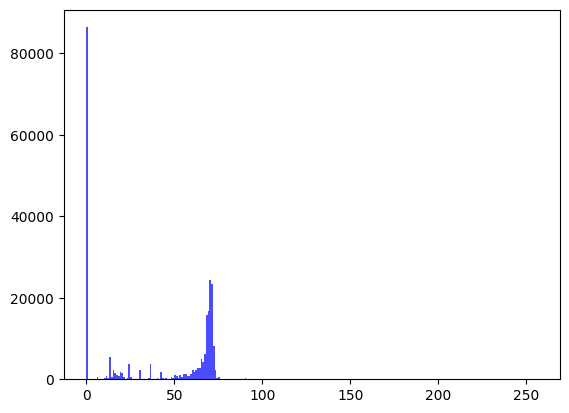

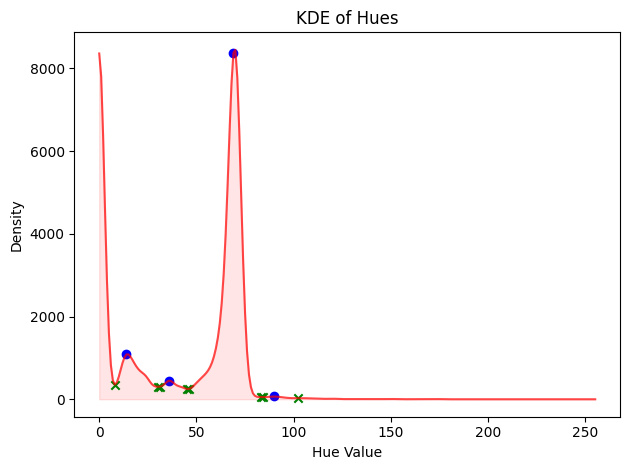

There are  4 Hue peaks


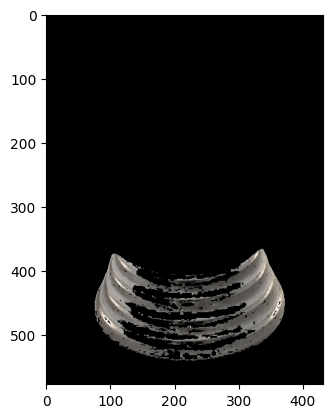

<Figure size 640x480 with 0 Axes>

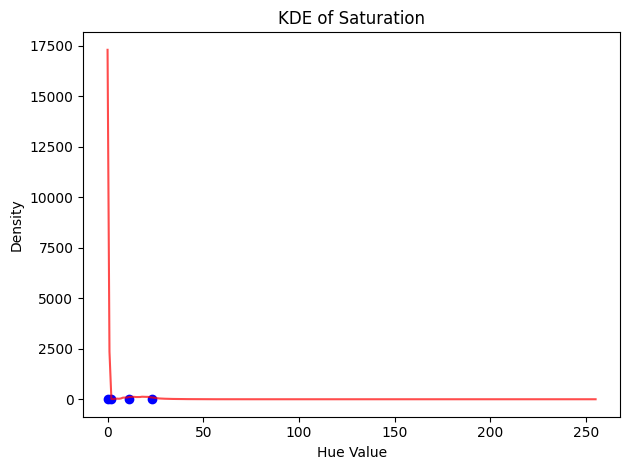

24031
there are several distinct peaks in saturation 2
[0, 2, 11, 23]


<Figure size 640x480 with 0 Axes>

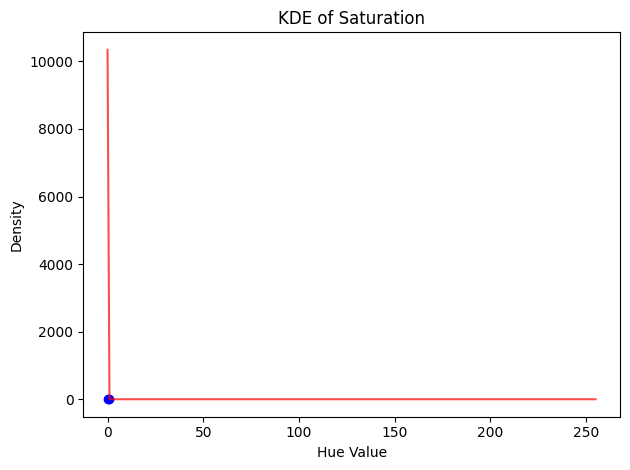

no value detected:set to 0


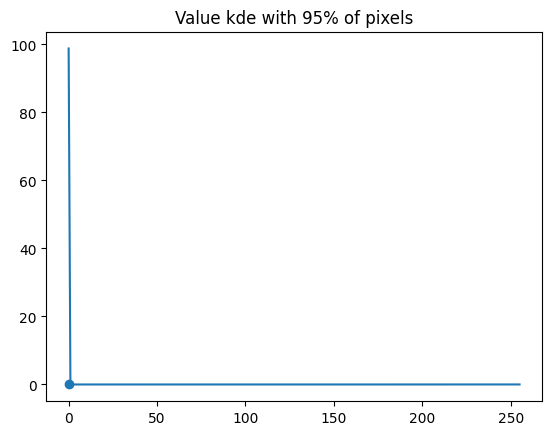

[0, 2, 11, 23]


<Figure size 640x480 with 0 Axes>

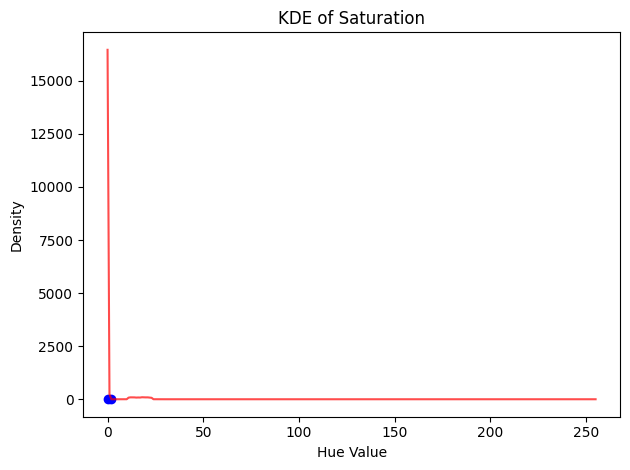

105 v_end


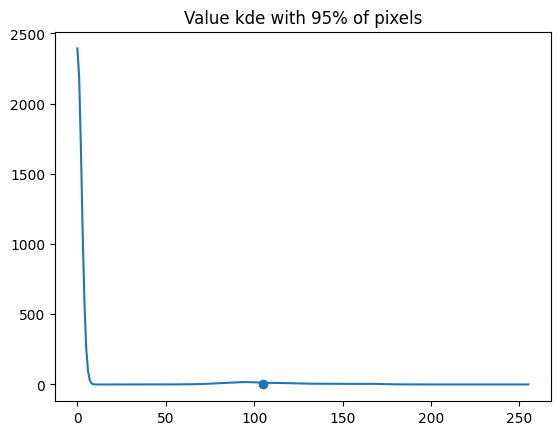

131 v_end


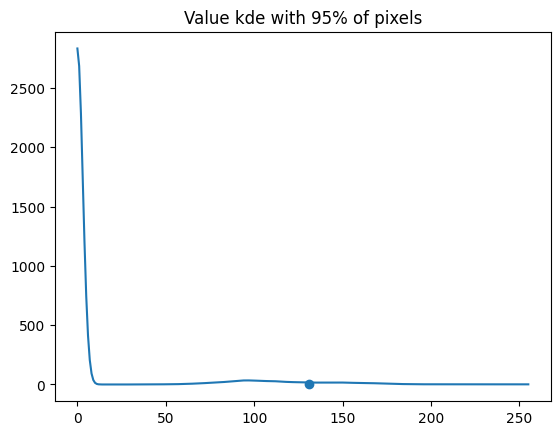

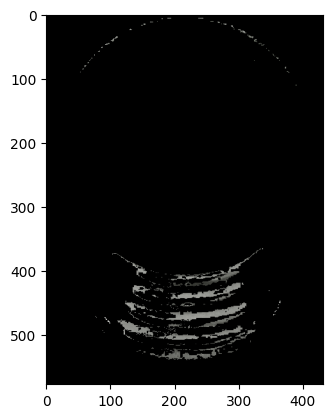

<Figure size 640x480 with 0 Axes>

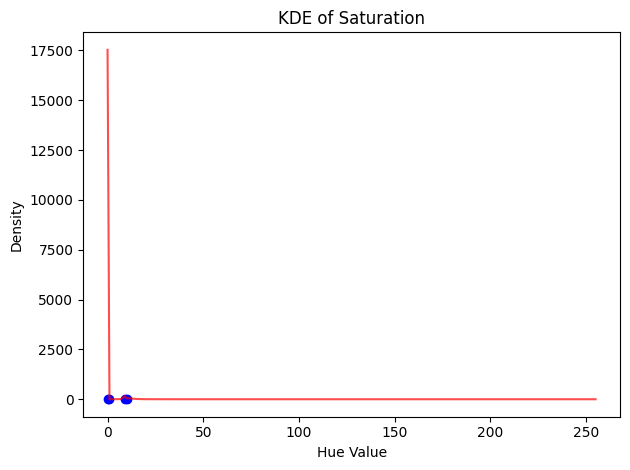

7124
there are several distinct peaks in saturation 2
[0, 1, 9, 10]
[0, 1, 9, 10]


<Figure size 640x480 with 0 Axes>

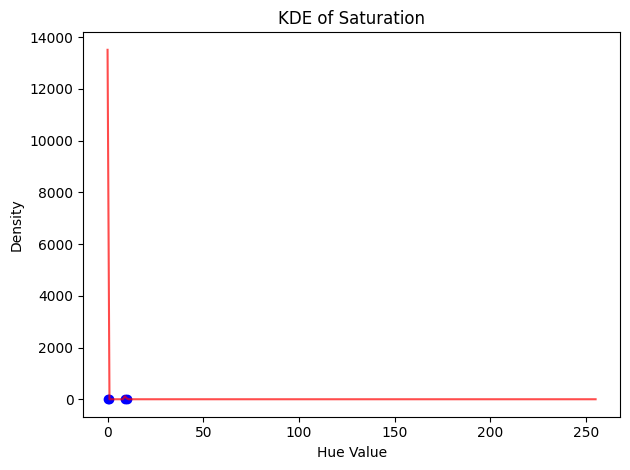

1 v_end


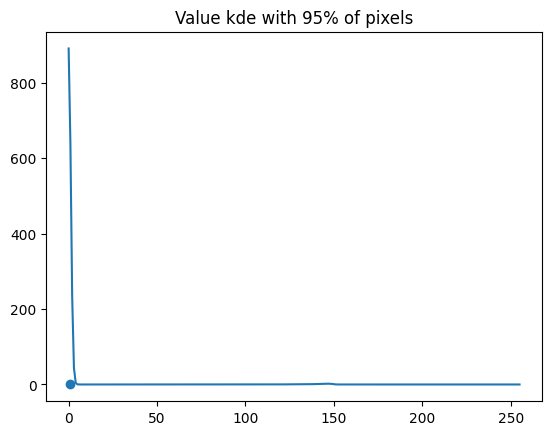

4 v_end


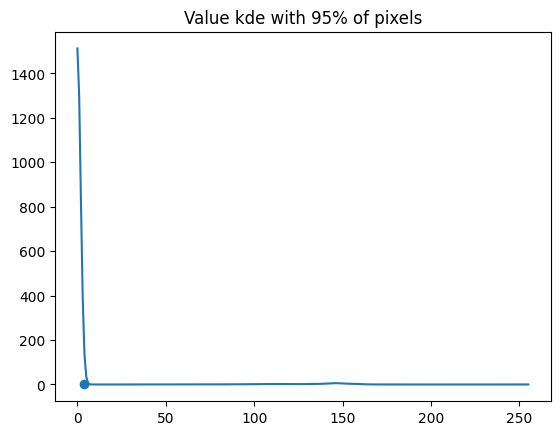

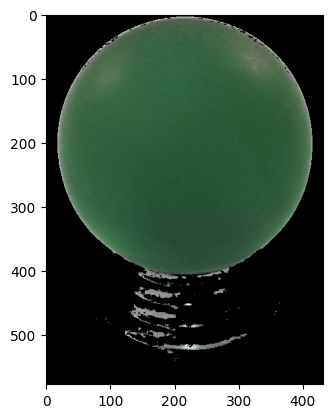

<Figure size 640x480 with 0 Axes>

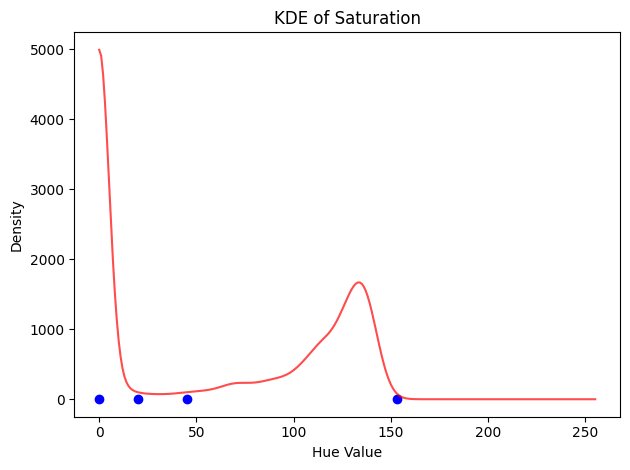

129386
there are several distinct peaks in saturation 2
[0, 20, 45, 153]


<Figure size 640x480 with 0 Axes>

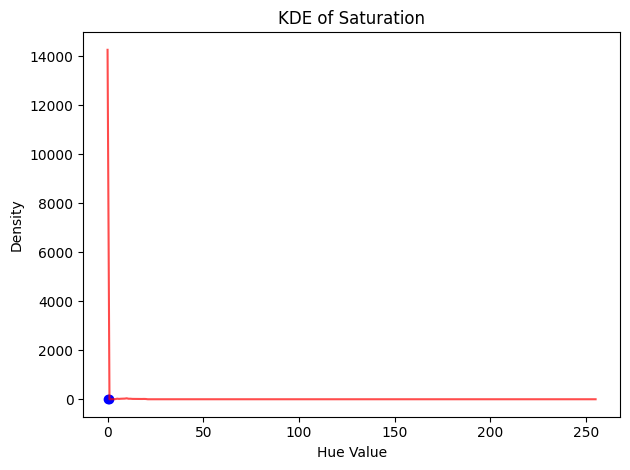

3 v_end


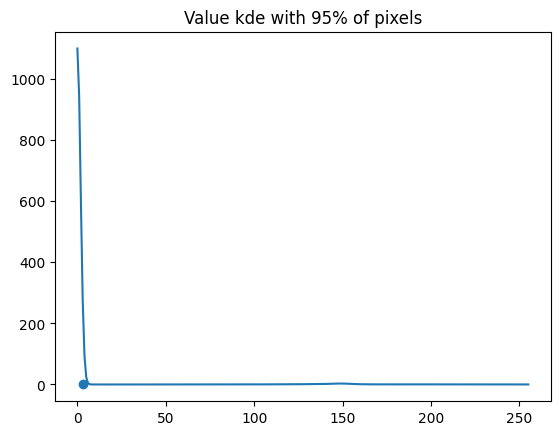

[0, 20, 45, 153]


<Figure size 640x480 with 0 Axes>

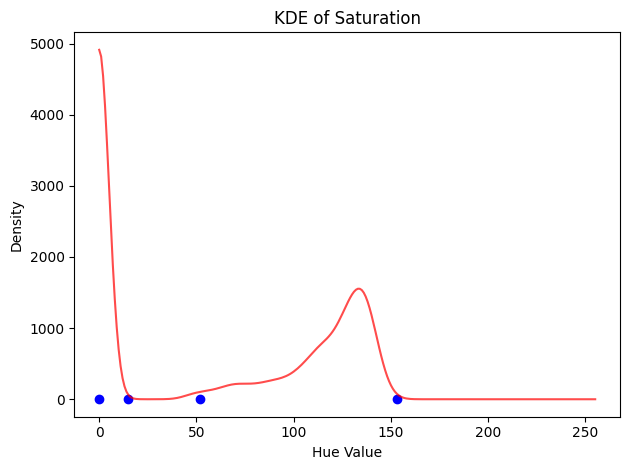

110 v_end


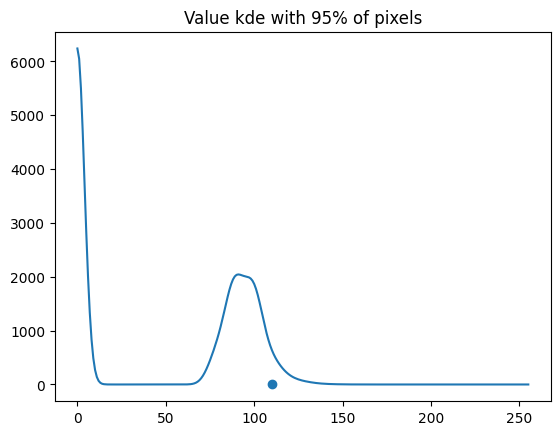

118 v_end


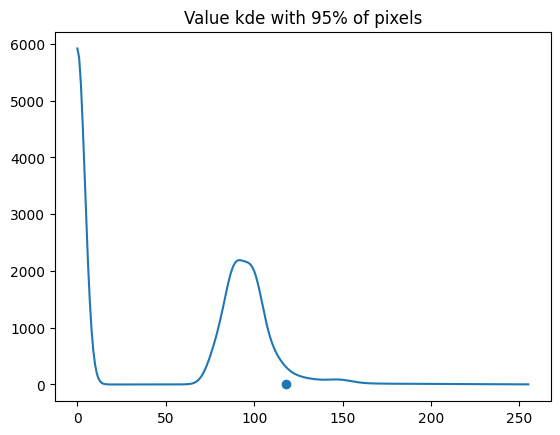

invalid material due to few pixels: 0


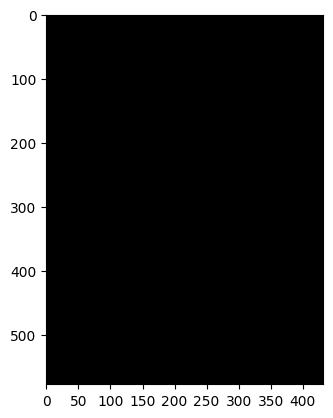

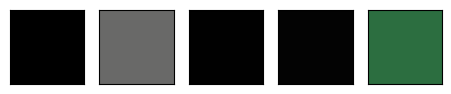

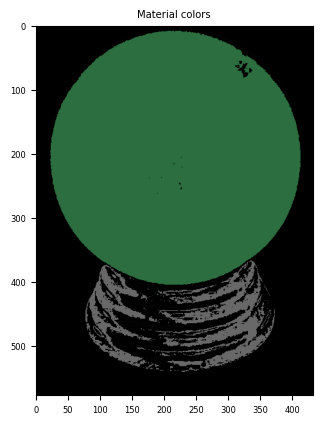

In [10]:
#rgb_img = imageio.imread("photos/lego_sample.png")
rgb_img = imageio.imread("photos/materials_sample-removebg-preview.png")
volume_properties=[]

material_colors_img, material_shading_img= hsv_analysis_new(rgb_img,1)
show_vp(volume_properties, len(volume_properties) )
show_material_img(material_colors_img)

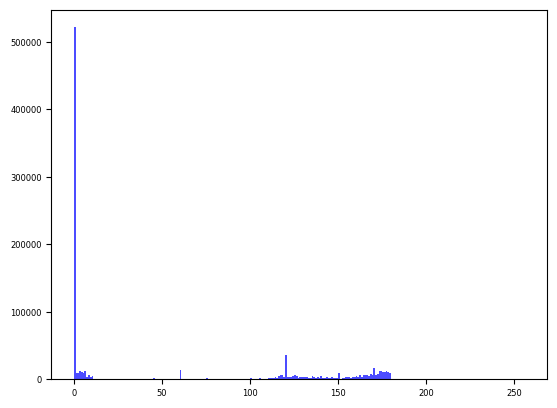

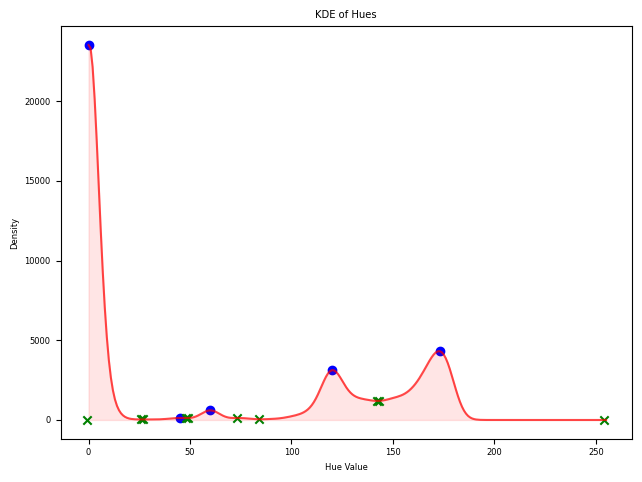

There are  5 Hue peaks


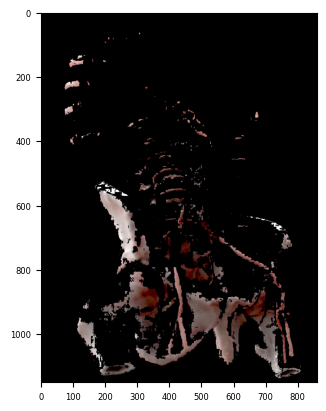

<Figure size 640x480 with 0 Axes>

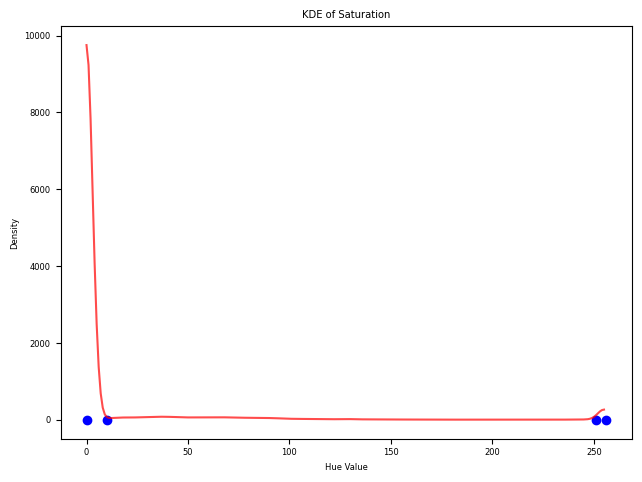

83882
there are several distinct peaks in saturation 2
[0, 10, 251, 256]


<Figure size 640x480 with 0 Axes>

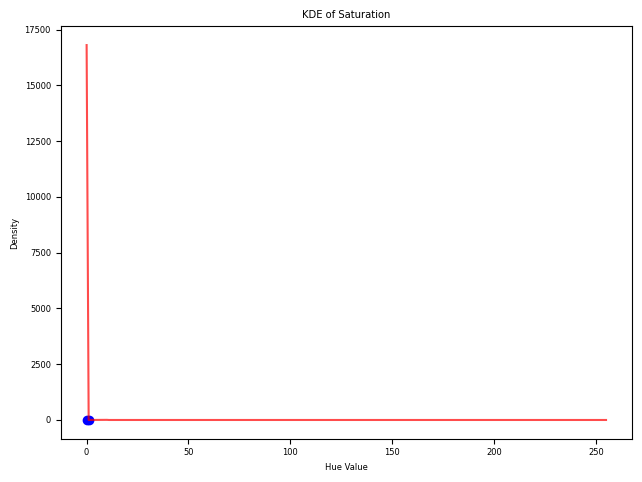

0 v_end


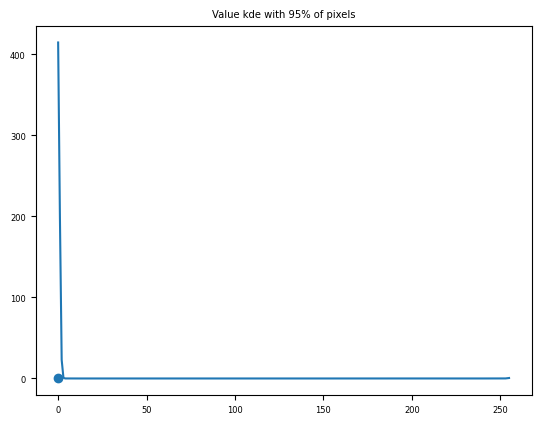

[0, 10, 251, 256]


<Figure size 640x480 with 0 Axes>

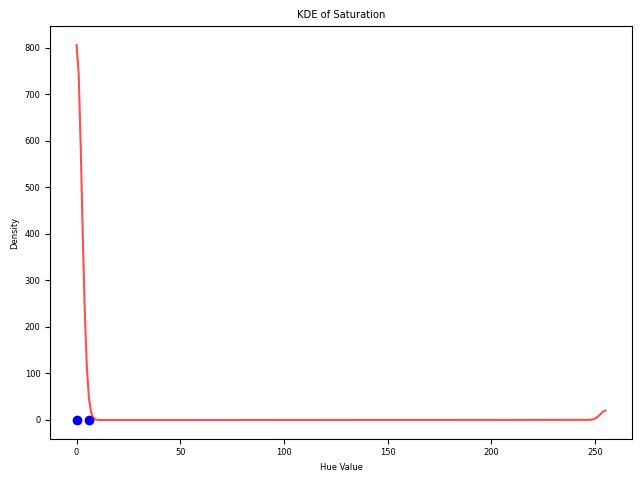

no value detected:set to 0


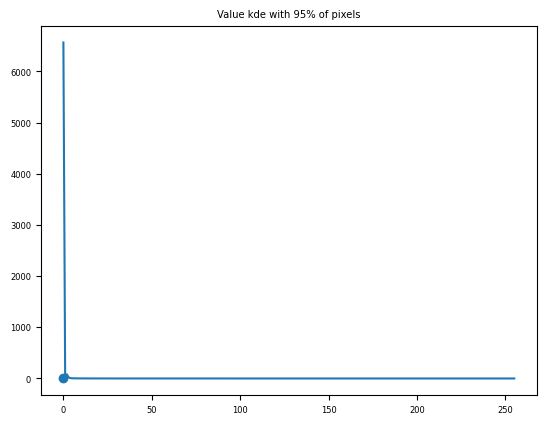

149 v_end


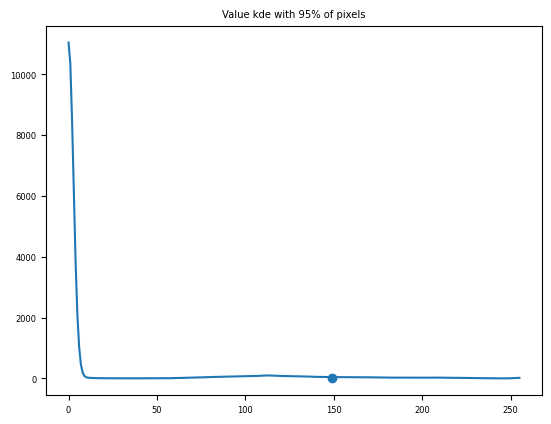

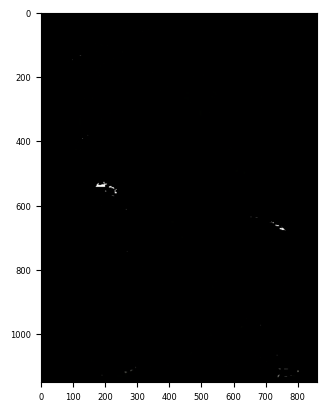

<Figure size 640x480 with 0 Axes>

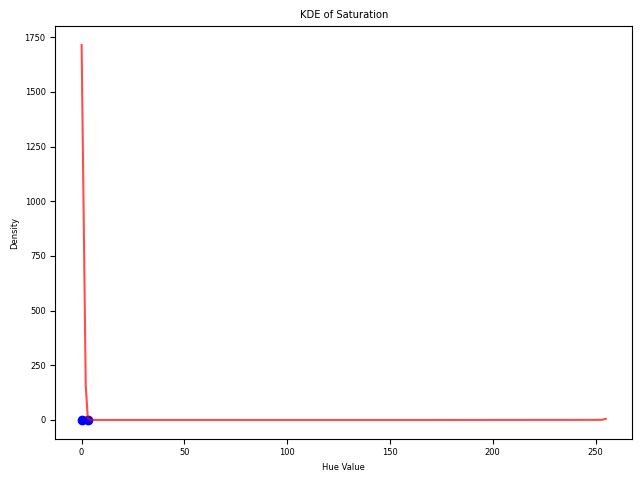

3953
there is only one distinct peak in saturation
no value detected:set to 0


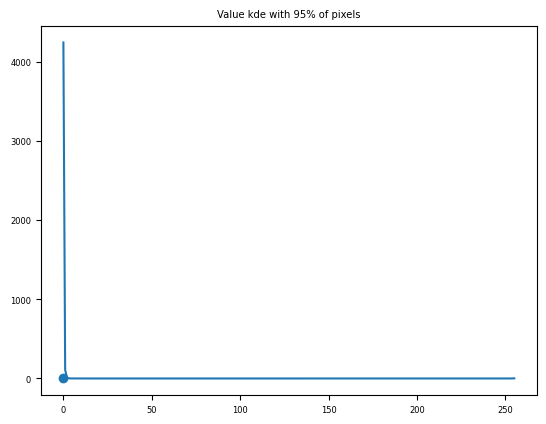

there are distinct peaks in saturation and value, here are the saturation and value histograms
final color of object
number of pixels of object above 3953 , HSV 45 3 0


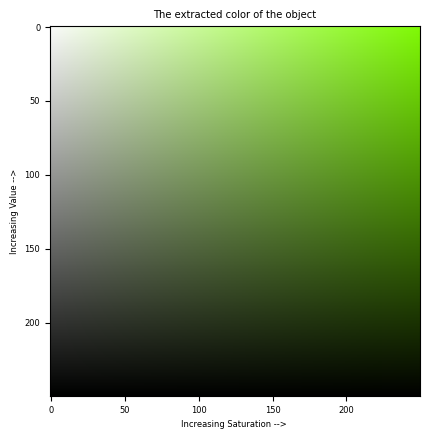

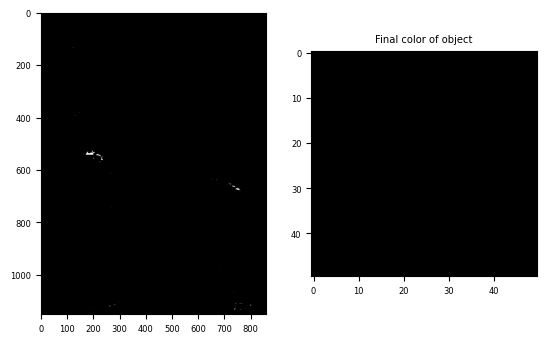

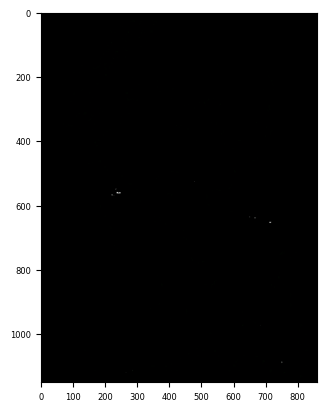

<Figure size 640x480 with 0 Axes>

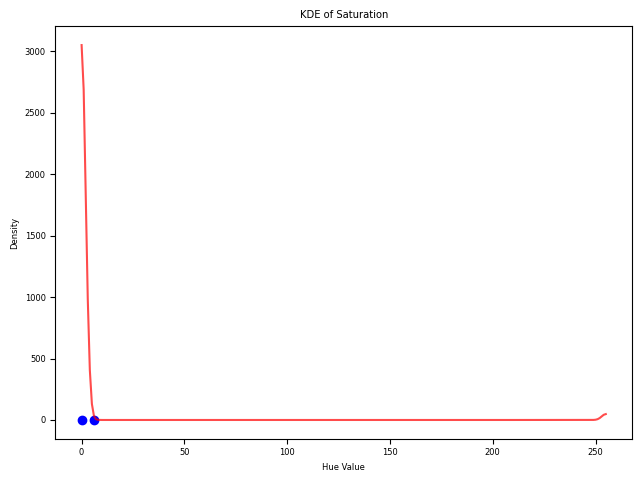

15467
there is only one distinct peak in saturation
no value detected:set to 0


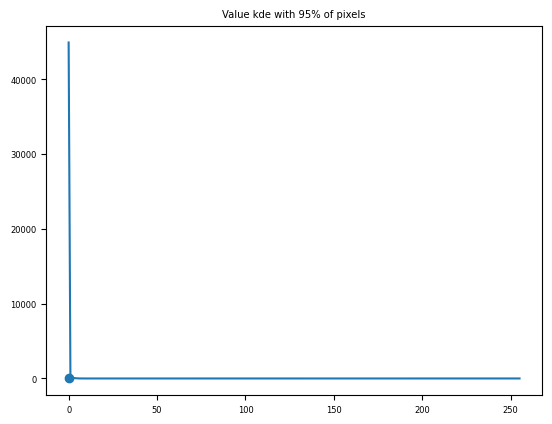

there are distinct peaks in saturation and value, here are the saturation and value histograms
final color of object
number of pixels of object above 15467 , HSV 60 6 0


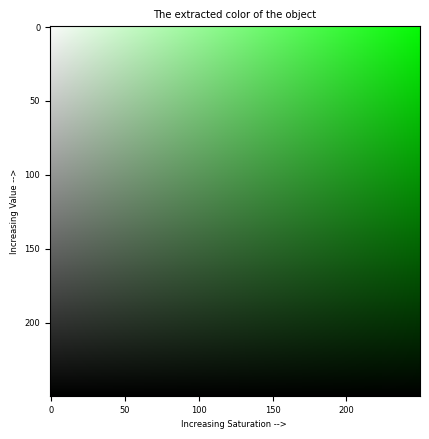

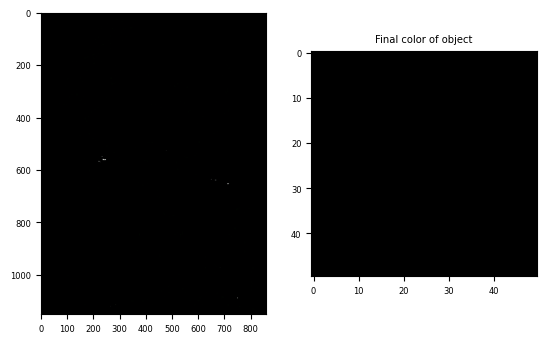

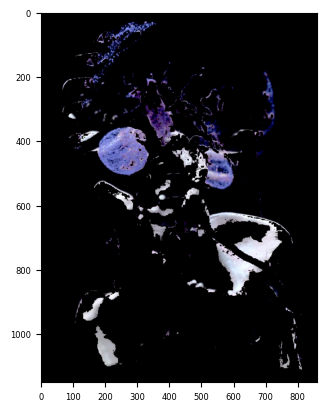

<Figure size 640x480 with 0 Axes>

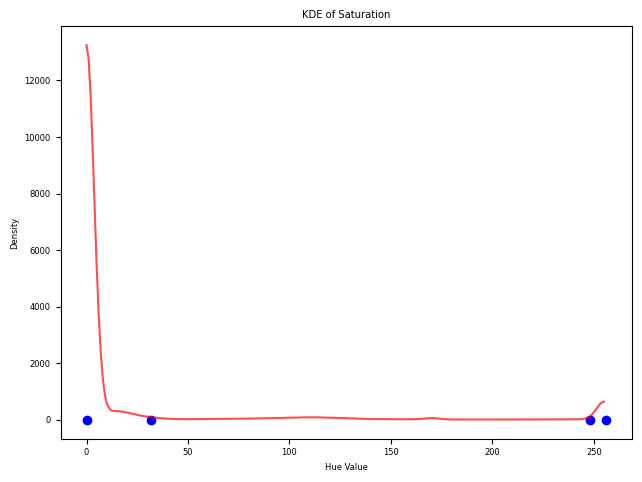

144303
there are several distinct peaks in saturation 2
[0, 32, 248, 256]


<Figure size 640x480 with 0 Axes>

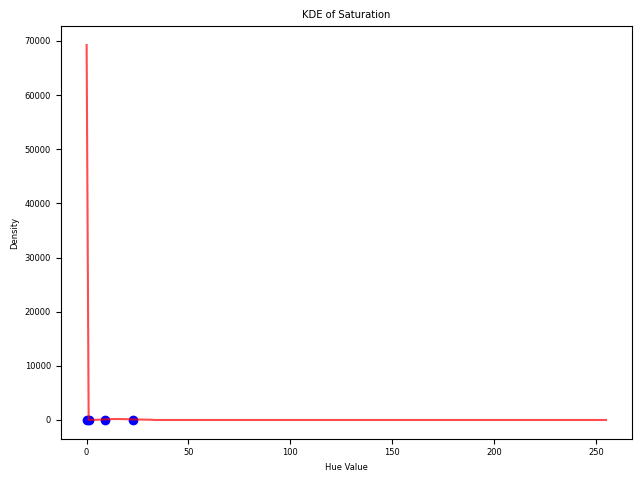

186 v_end


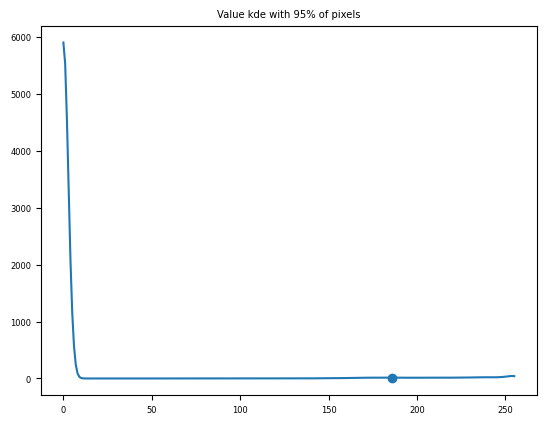

[0, 32, 248, 256]


<Figure size 640x480 with 0 Axes>

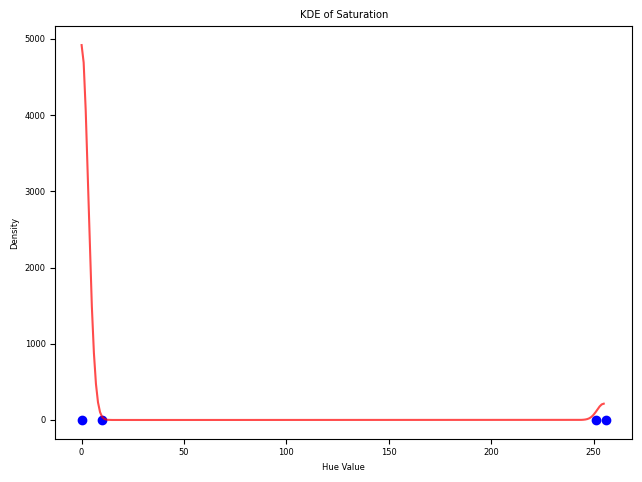

no value detected:set to 0


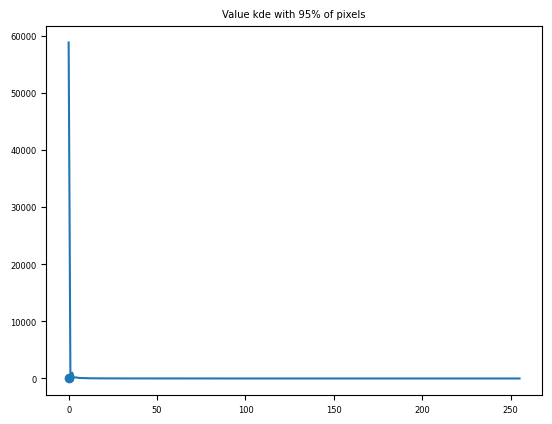

207 v_end


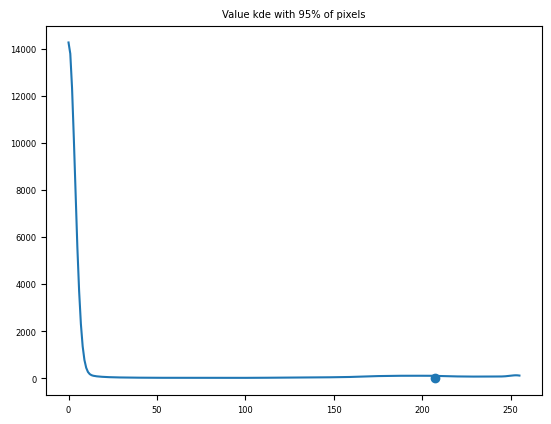

invalid material due to few pixels: 0


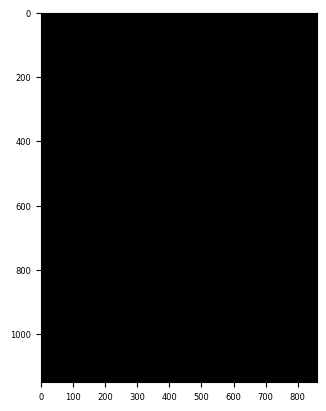

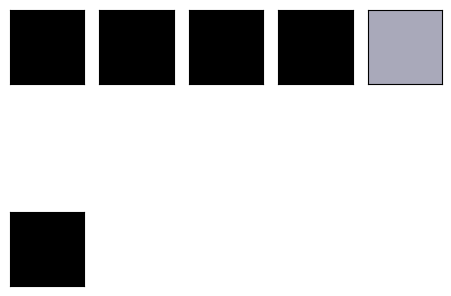

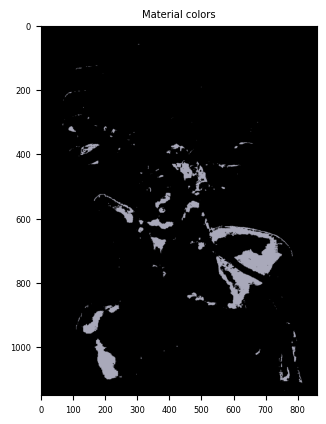

In [11]:
#rgb_img = imageio.imread("photos/lego_sample.png")
#rgb_img = imageio.imread("photos/materials_sample-removebg-preview.png")
#rgb_img = imageio.imread("photos/coloured_cubes_sample.jpg")
rgb_img = imageio.imread("photos/pretty_image.png")

volume_properties=[]
material_colors_img, material_shading_img= hsv_analysis_new(rgb_img,1)

show_vp(volume_properties, len(volume_properties) )
show_material_img(material_colors_img)

In [ ]:
def calc_sat_kde_minima(sat_values, total_pixels_masked):
    plt.figure()  

    # Calculate the KDE (Kernel Density Estimation) of hues
    kde = gaussian_kde(sat_values)

    # Plot the KDE
    x_vals = np.linspace(0, 255, 1000)
    x_integers = np.arange(0, 256)
    kde_histogram=  kde(x_integers)*total_pixels_img

    local_minima = np.where((kde_histogram[1:-1] < kde_histogram[0:-2]) * (kde_histogram[1:-1] < kde_histogram[2:]))[0] + 1

    
    #thresholding 
    s_hist_tr, s_hist_pulse_area, s_pulse_start_end= thresholding(threshold, kde_histogram)
    s_zeros= np.zeros(len(s_pulse_start_end))
    plt.figure()   
    plt.plot(x_integers, kde_histogram, color='red', alpha=0.7)
    plt.scatter( s_pulse_start_end,s_zeros,  color='blue')
    plt.title('KDE of Saturation')
    plt.xlabel('Hue Value')
    plt.ylabel('Density')

    plt.tight_layout()
    plt.show()

    return kde_histogram, s_pulse_start_end